In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import ktrain
from sklearn.model_selection import train_test_split
from ktrain import text
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohsenboughriou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohsenboughriou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
df_t=pd.read_excel('.../train.xlsx')
df_test=pd.read_excel('.../test.xlsx')

In [3]:
df=pd.concat([df_t,df_test],axis=0)

In [4]:
#We have 27 intention categories, we change them into numeric labels.
le = preprocessing.LabelEncoder()
le.fit(df['Intent'])
y_train=le.transform(df['Intent'])

In [5]:
#we clean our training samples by excluding some of the irrrelevant characters and stop words

def preprocess(X):
    X= df['Example'].str.replace('\s+',' ')
    X = X.str.replace('[-?:.!]', '')
    
    X= np.array([s.strip() for s in X])
    X=np.array([s.lower() for s in X]) 

    stopwords = nltk.corpus.stopwords.words("english")
    X=np.array([s.split() for s in X])


    corpus=  list(map(lambda x: [item for item in x if item not in stopwords],X))
    X_train=[]

    for sentences in corpus:
        X_train.append(sentences)

    for i in range(len(X_train)):
        X_train[i]=' '.join(X_train[i])
        
    return X_train
X_train=df['Example']    
X_train=preprocess(X_train)

/var/folders/xb/qwgsqylj7j7c10t_q8rvnf_c0000gn/T/ipykernel_1411/3063527325.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X=np.array([s.split() for s in X])


In [6]:
y_train=np.array(y_train)
X_train=np.array(X_train)

In [7]:
from tensorflow.keras.preprocessing.text import one_hot
voc_size=1000

onehot_examples = [one_hot(words, voc_size) for words in X_train]
onehot_examples

[[686, 605, 177, 739, 308],
 [68, 739],
 [740, 967, 977, 411, 739, 308],
 [607, 977, 739, 308],
 [758, 177, 739, 308],
 [795, 177, 739, 308],
 [686, 800, 758, 739, 656],
 [53, 795, 68, 739],
 [758, 177, 739, 308],
 [795, 68, 411, 739],
 [758, 177, 411, 739, 308],
 [740, 967, 977, 739, 308],
 [78, 977, 739],
 [686, 800, 177, 739],
 [740, 967, 68, 129],
 [740, 967, 977, 739, 308],
 [967, 977, 739, 308],
 [337, 68, 411, 739],
 [795, 177, 411, 739],
 [607, 68, 129],
 [167, 68, 739],
 [967, 68, 739, 308],
 [740, 795, 68, 739, 308],
 [167, 68, 739],
 [293, 691, 739, 308],
 [607, 68, 129],
 [167, 977, 129],
 [955, 78, 977, 129],
 [293, 967, 68, 739, 308],
 [177, 739],
 [734, 78, 739, 581],
 [220, 78, 68, 129],
 [337, 68, 411, 739],
 [758, 177, 411, 739],
 [167, 977, 411, 739],
 [607, 68, 739, 308],
 [740, 795, 977, 411, 739, 308],
 [734, 78, 68, 129],
 [293, 758, 739, 581],
 [293, 795, 177, 739, 308],
 [293, 967, 977, 739],
 [795, 177, 411, 739, 308],
 [220, 78, 68, 129],
 [795, 68, 739],
 [3

In [11]:
#we check the length of the longest sentence to consider it as a max length, whereas shorter sentences will be padded.
l=[]
for lists in onehot_examples:
    l.append(len(lists))
print('The longest sentence in our training data contains exaclty',np.max(l),'tokens')   

The longest sentence in our training data contains : 8 tokens


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len=8
embedded_examples=pad_sequences(onehot_examples,padding='pre',maxlen=max_len)
print(embedded_examples)

[[  0   0   0 ... 177 739 308]
 [  0   0   0 ...   0  68 739]
 [  0   0 740 ... 411 739 308]
 ...
 [  0   0   0 ... 399 263 722]
 [  0   0   0 ... 795 144 263]
 [  0   0   0 ... 211 144 263]]


In [13]:
X_train,X_val,y_train,y_val=train_test_split(embedded_examples, y_train, test_size=0.1, random_state=42)

In [18]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [19]:
embedding_vector_features=30
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dense(units=27, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 30)             30000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              104800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 27)                5427      
                                                                 
Total params: 140,227
Trainable params: 140,227
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,batch_size=512)

Epoch 1/10
15/15 [==============================] - 2s 70ms/step - loss: 2.5162 - accuracy: 0.3462 - val_loss: 0.9459 - val_accuracy: 0.6993
Epoch 2/10
15/15 [==============================] - 1s 33ms/step - loss: 0.3603 - accuracy: 0.9042 - val_loss: 0.1114 - val_accuracy: 0.9694
Epoch 3/10
15/15 [==============================] - 0s 33ms/step - loss: 0.0608 - accuracy: 0.9867 - val_loss: 0.0593 - val_accuracy: 0.9817
Epoch 4/10
15/15 [==============================] - 1s 36ms/step - loss: 0.0229 - accuracy: 0.9951 - val_loss: 0.0309 - val_accuracy: 0.9939
Epoch 5/10
15/15 [==============================] - 0s 32ms/step - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.0276 - val_accuracy: 0.9927
Epoch 6/10
15/15 [==============================] - 1s 35ms/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.0349 - val_accuracy: 0.9878
Epoch 7/10
15/15 [==============================] - 0s 32ms/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.0310 - val_accuracy: 0.9902
Epoch 8/10
15

In [40]:
model.save(".../bilstm")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


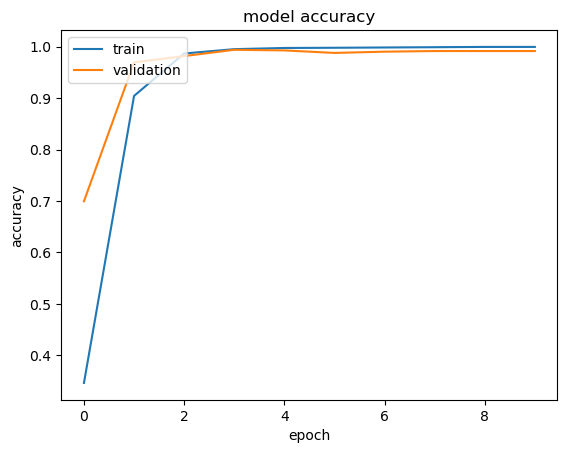

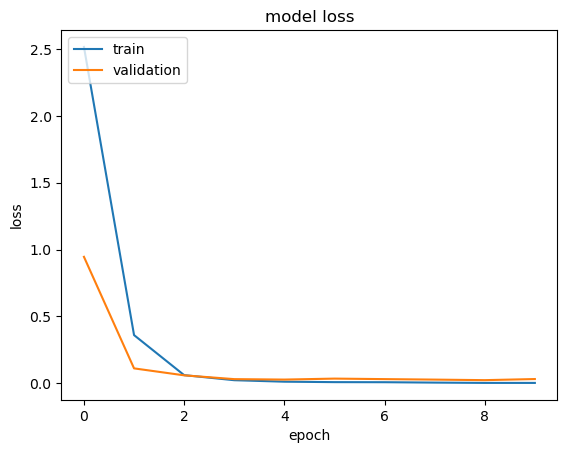

In [21]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
y_val_pred=model.predict(X_val)

26/26 [==============================] - 0s 6ms/step


In [25]:
val_pred=[]
for lists in y_val_pred:
    val_pred.append(np.argmax(lists))

In [27]:
val_pred = to_categorical(val_pred)

In [39]:
target_name=['cancel_order', 'change_order', 'change_shipping_address',
       'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
       'check_refund_policy', 'complaint', 'contact_customer_service',
       'contact_human_agent', 'create_account', 'delete_account',
       'delivery_options', 'delivery_period', 'edit_account',
       'get_invoice', 'get_refund', 'newsletter_subscription',
       'payment_issue', 'place_order', 'recover_password',
       'registration_problems', 'review', 'set_up_shipping_address',
       'switch_account', 'track_order', 'track_refund']
print(classification_report(y_val,val_pred,target_names=target_name))


                          precision    recall  f1-score   support

            cancel_order       1.00      1.00      1.00        32
            change_order       1.00      1.00      1.00        32
 change_shipping_address       0.97      1.00      0.98        30
  check_cancellation_fee       1.00      1.00      1.00        32
           check_invoice       1.00      1.00      1.00        24
   check_payment_methods       1.00      0.94      0.97        33
     check_refund_policy       1.00      1.00      1.00        32
               complaint       0.92      1.00      0.96        23
contact_customer_service       1.00      1.00      1.00        23
     contact_human_agent       1.00      1.00      1.00        36
          create_account       1.00      0.96      0.98        28
          delete_account       1.00      1.00      1.00        28
        delivery_options       0.97      1.00      0.98        29
         delivery_period       1.00      1.00      1.00        27
         